# ThE raNDom WALkERS - Notebook report
__Members:__ Jonathan Doenz, Wentao Feng, Yuxuan Wang

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import pickle
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, trange

from funcs import *
from MH import *
from beta_optimizer import BetaOptimizer

In [ ]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
%matplotlib inline

plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 16

In [4]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()

    def refresh(self):
        raise Exception("undefined")

class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

## Compute optimal $\beta(\epsilon)$

In [ ]:
# Directory in which file with optimal betas are stored
generated_data_dir = 'generated_data'

# Constants
N = 100 # Number of cities
n_iterations = 10000 # Number of iterations for optimizing betas

In [12]:
def compute_optimal_betas(model_string, N, lambda_vec, n_iterations):
    """Return a Pandas dataframe with optimal values of beta."""
    if model_string == 'G1':
        generator_class = G1
    else:
        generator_class = G2

    n_beta_iterations = 100
    epsilon_vec = np.linspace(0.05, 0.95, 10)
    beta_vec_list = []
    lambda_arrays_list = []
    for lambda_ in tqdm(lambda_vec):
        for i in range(n_beta_iterations):
            bo = BetaOptimizer(generator_class, lambda_, N, n_iterations, verbose=False)
            bo.run()
            try:
                beta_vec = compute_beta_vec(bo, epsilon_vec)
            except IndexError:
                pass
            else:
                beta_vec_list.append(beta_vec)
        lambda_arrays_list.append(np.array(beta_vec_list))

    optimal_betas_df = get_optimal_betas_df(lambda_vec, epsilon_vec, lambda_arrays_list, model_string)
    return optimal_betas_df

### Generative model $\mathcal{G}_1$

In [8]:
lambda_vec = np.linspace(0, 1, 11)
optimal_betas_G1_df = compute_optimal_betas('G1', N, lambda_vec, n_iterations)

### Generative model $\mathcal{G}_2$

In [13]:
lambda_vec = np.linspace(0, 2, 21)
optimal_betas_G2_df = compute_optimal_betas('G2', N, lambda_vec, n_iterations)

In [14]:
# Concatenate results for G1 and G2
optimal_betas_df = optimal_betas_G1_df.append(optimal_betas_G2_df)

# Save results to file
optimal_betas_df.to_csv(os.path.join(generated_data_dir, 'G1_and_G2_optimal_betas.csv'), index=False)

## Metropolis-Hastings

### Results on $\mathcal{G}_1$

In [15]:
g1 = G1(100)
g1.refresh()
gname = 'G1'

lam = 1
num_iters = 2000
beta_schedule = getOptBetaSeq(gname, lam)
beta = beta_schedule[0]
beta_interp = interpBetas(beta_schedule, num_iters, smooth=False)

Original lambda is 1 Corrected one is 1.0


In [6]:
inputs = {'v': g1.v, 'x': g1.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g1.v), dtype=bool)
optim = optimizer(objective, transition, beta, init_state, **inputs)
val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_schedule, reset=True)
num_cities = np.sum(num_cities, axis=1)

<Figure size 800x480 with 0 Axes>

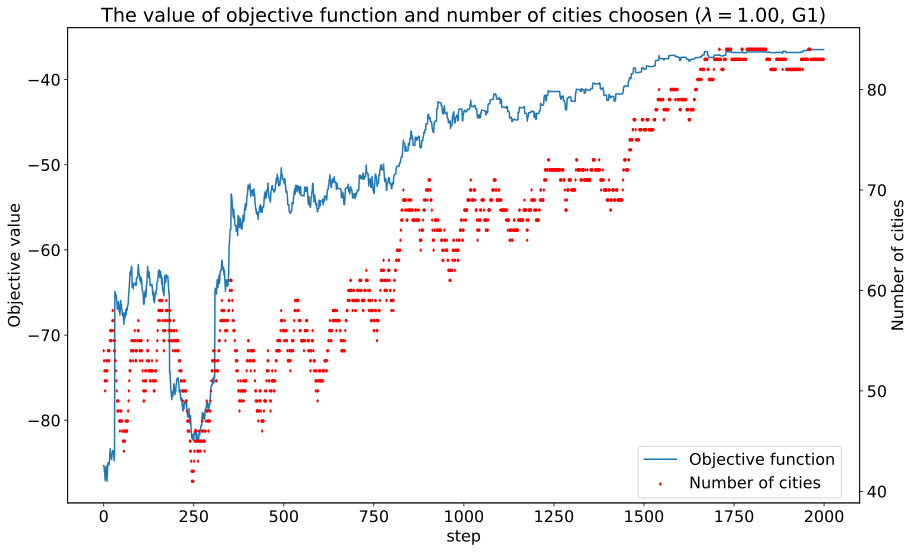

In [16]:
plt.clf()
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 8)
ax1.plot(range(num_iters), val, label='Objective function')
ax1.set_xlabel('step')
ax1.set_ylabel('Objective value')
ax1.set_title(r'The value of objective function and number of cities choosen ($\lambda={0:.2f}$, {1:s})'.format(lam, gname))

ax2 = ax1.twinx()
ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='Number of cities')
ax2.set_ylabel('Number of cities')
fig.legend(loc='lower right', bbox_to_anchor=(0.92, 0.1))
fig.tight_layout()

$E_{\mathcal{G}_1}[\|\mathcal{S}^{*}(\lambda)\|], E_{\mathcal{G}_1}[f(\lambda, \mathcal{S}^{*}(\lambda))]$

In [20]:
all_val =  []
all_num_city  = []
all_lam = np.round(np.arange(0, 1.1, 0.1), 2)
g = G1(100)
gname = 'G1'
for lam in tqdm(all_lam):
    beta_schedule = getOptBetaSeq(gname, lam)
    beta = beta_schedule[0]
    curr_val = []
    curr_num_city = []
    for _ in trange(20):
        g.refresh()
        inputs = {'v': g.v, 'x': g.x, 'lam': lam}
        init_state = np.random.randint(0, 2, size=len(g.v), dtype=bool)
        optim = optimizer(objective, transition, beta, init_state, **inputs)
        num_iters = 2000
        val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_schedule, reset=True)
        num_cities = np.sum(num_cities, axis=1)
        optim_val, optim_cities = getMaxVal(val, num_cities)
        curr_val.append(optim_val)
        curr_num_city.append(optim_cities)
    all_val.append(curr_val)
    all_num_city.append(curr_num_city)
all_val = np.array(all_val)
all_num_city = np.array(all_num_city)
expe_g1_f = np.mean(all_val, axis=1)
expe_g1_s = np.mean(all_num_city, axis=1)

Original lambda is 0.0 Corrected one is 0.0



Original lambda is 0.1 Corrected one is 0.1



Original lambda is 0.2 Corrected one is 0.2



Original lambda is 0.3 Corrected one is 0.3



Original lambda is 0.4 Corrected one is 0.4



Original lambda is 0.5 Corrected one is 0.5



Original lambda is 0.6 Corrected one is 0.6



Original lambda is 0.7 Corrected one is 0.7



Original lambda is 0.8 Corrected one is 0.8



Original lambda is 0.9 Corrected one is 0.9



Original lambda is 1.0 Corrected one is 1.0


<Figure size 800x480 with 0 Axes>

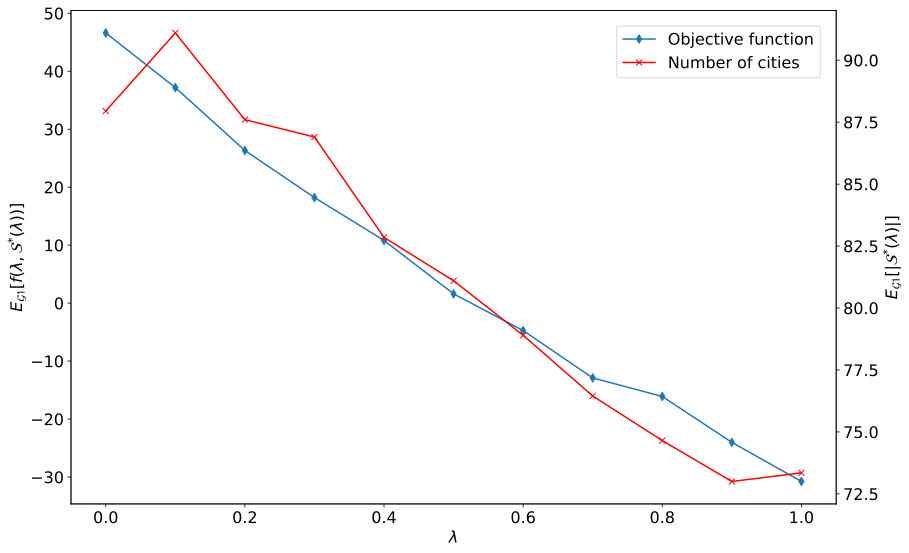

In [22]:
plt.clf()
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 8)
ax1.plot(all_lam, expe_g1_f, 'd-', label='Objective function')
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('$E_\mathcal{G1}[f(\lambda, \mathcal{S}^{*}(\lambda))]$')

ax2 = ax1.twinx()
ax2.plot(all_lam, expe_g1_s, 'rx-', label='Number of cities')
ax2.set_ylabel('$E_\mathcal{G1}[\|\mathcal{S}^{*}(\lambda)\|]$')
fig.legend(bbox_to_anchor=(0.9, 0.95))
fig.tight_layout()

### Results on $\mathcal{G}_2$

In [25]:
g2 = G2(100)
g2.refresh()
gname = 'G2'

lam = 1.5
num_iters = 2000
beta_schedule = getOptBetaSeq(gname, lam)
beta = beta_schedule[0]
beta_interp = interpBetas(beta_schedule, num_iters, smooth=False)

Original lambda is 1.5 Corrected one is 1.5


In [26]:
inputs = {'v': g2.v, 'x': g2.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g2.v), dtype=bool)
optim = optimizer(objective, transition, beta, init_state, **inputs)
val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_schedule, reset=True)
num_cities = np.sum(num_cities, axis=1)

<Figure size 800x480 with 0 Axes>

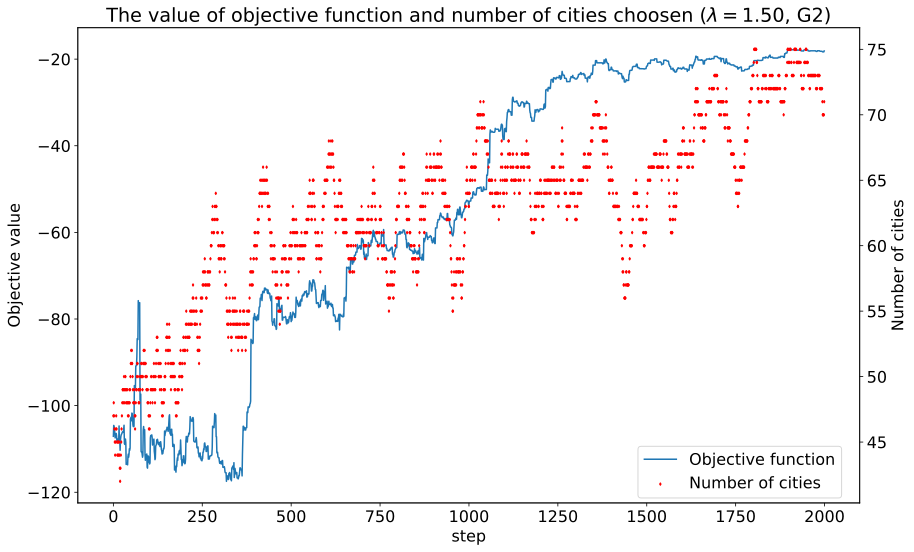

In [27]:
plt.clf()
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 8)
ax1.plot(range(num_iters), val, label='Objective function')
ax1.set_xlabel('step')
ax1.set_ylabel('Objective value')
ax1.set_title(r'The value of objective function and number of cities choosen ($\lambda={0:.2f}$, {1:s})'.format(lam, gname))

ax2 = ax1.twinx()
ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='Number of cities')
ax2.set_ylabel('Number of cities')
fig.legend(loc='lower right', bbox_to_anchor=(0.92, 0.1))
fig.tight_layout()

$E_{\mathcal{G}_2}[\|\mathcal{S}^{*}(\lambda)\|], E_{\mathcal{G}_2}[f(\lambda, \mathcal{S}^{*}(\lambda))]$

In [28]:
all_val =  []
all_num_city  = []
all_lam = np.round(np.arange(0, 1.1, 0.1), 2)
g = G2(100)
gname = 'G2'
for lam in tqdm(all_lam):
    beta_schedule = getOptBetaSeq(gname, lam)
    beta = beta_schedule[0]
    curr_val = []
    curr_num_city = []
    for _ in trange(20):
        g.refresh()
        inputs = {'v': g.v, 'x': g.x, 'lam': lam}
        init_state = np.random.randint(0, 2, size=len(g.v), dtype=bool)
        optim = optimizer(objective, transition, beta, init_state, **inputs)
        num_iters = 2000
        val, num_cities = optim.run(iters=num_iters, beta_schedule=beta_schedule, reset=True)
        num_cities = np.sum(num_cities, axis=1)
        optim_val, optim_cities = getMaxVal(val, num_cities)
        curr_val.append(optim_val)
        curr_num_city.append(optim_cities)
    all_val.append(curr_val)
    all_num_city.append(curr_num_city)
all_val = np.array(all_val)
all_num_city = np.array(all_num_city)
expe_g2_f = np.mean(all_val, axis=1)
expe_g2_s = np.mean(all_num_city, axis=1)

Original lambda is 0.0 Corrected one is 0.0



Original lambda is 0.1 Corrected one is 0.1



Original lambda is 0.2 Corrected one is 0.2



Original lambda is 0.3 Corrected one is 0.3



Original lambda is 0.4 Corrected one is 0.4



Original lambda is 0.5 Corrected one is 0.5



Original lambda is 0.6 Corrected one is 0.6



Original lambda is 0.7 Corrected one is 0.7



Original lambda is 0.8 Corrected one is 0.8



Original lambda is 0.9 Corrected one is 0.9



Original lambda is 1.0 Corrected one is 1.0


<Figure size 800x480 with 0 Axes>

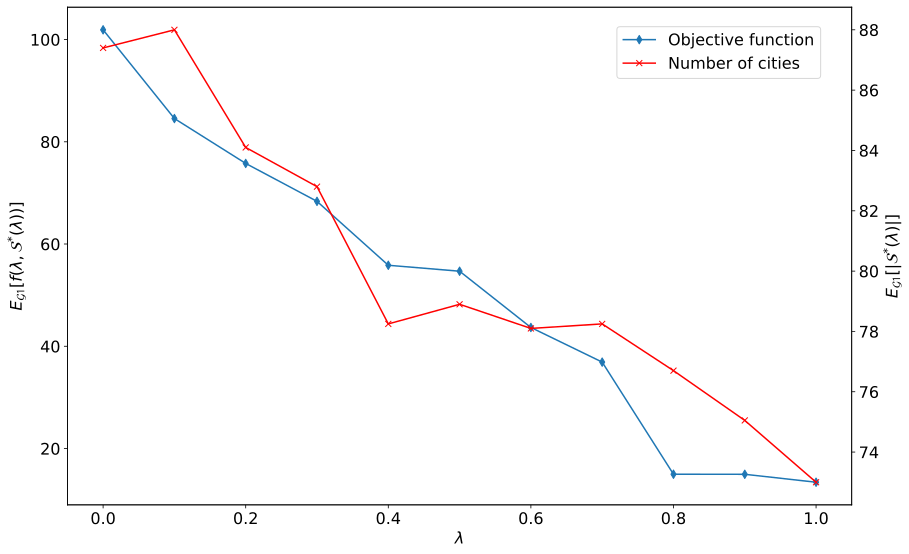

In [29]:
plt.clf()
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 8)
ax1.plot(all_lam, expe_g2_f, 'd-', label='Objective function')
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('$E_\mathcal{G1}[f(\lambda, \mathcal{S}^{*}(\lambda))]$')

ax2 = ax1.twinx()
ax2.plot(all_lam, expe_g2_s, 'rx-', label='Number of cities')
ax2.set_ylabel('$E_\mathcal{G1}[\|\mathcal{S}^{*}(\lambda)\|]$')
fig.legend(bbox_to_anchor=(0.9, 0.95))
fig.tight_layout()